In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers


Bad key "text.kerning_factor" on line 4 in
/home/teguh/miniconda3/envs/tf3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Generate Dataset

In [2]:
K = 1
D = 2
mixture_of_gaussians = tfd.MixtureSameFamily(
    mixture_distribution = tfd.Categorical(logits=tf.ones(K)) , 
    components_distribution = tfd.MultivariateNormalDiag(loc=tf.random.normal((K,D))*3,
                                                        scale_diag=tf.math.softplus(tf.random.normal((K,D)))))
    
    

In [3]:
samples = mixture_of_gaussians.sample(10000)

In [67]:
from scipy.stats import multivariate_normal as mvn

N = 50000
x_dim = 1
y_dim = 1
noise_std_true = 0.5


# Generate data
#The dataset 1 is unimodal, the dataset 2 is multimodal

dataset_nb = 2

if dataset_nb == 1:
    b_true = np.random.randn(y_dim).astype(np.float32)   
    w_true = np.random.randn(x_dim, y_dim).astype(np.float32) 
    x = np.linspace(-10., 100., N)[None].T
    x = np.float32(x)
    noise = noise_std_true * np.random.randn(N,y_dim).astype(np.float32)
    y = np.matmul((x-50)**2, w_true)/100. + b_true + noise
    
elif dataset_nb == 2:
    radius = np.abs(np.random.normal(loc=0., scale=1., size=(N//2,1)))
    theta = np.random.uniform(low=0., high=2*np.pi, size=(N//2,1))
    x1 = radius * np.cos(theta)
    y1 = radius * np.sin(theta)
    
    radius = np.abs(np.random.normal(loc=10., scale=1., size=(N//2,1)))
    theta = np.random.uniform(low=0., high=2*np.pi, size=(N//2,1))
    x2 = radius * np.cos(theta)
    y2 = radius * np.sin(theta)
    
    x = np.vstack([x1, x2])
    y = np.vstack([y1, y2])

In [68]:
x = x - np.mean(x)
x /= np.std(x)
y = y - np.mean(y)
y /= np.std(y)

In [69]:
samples = np.hstack([x,y])

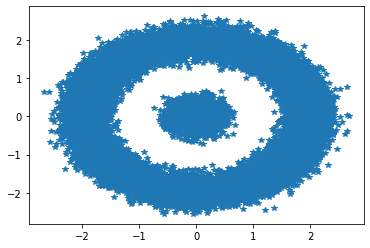

In [70]:
plt.plot(samples[:,0], samples[:,1], '*')

### Learn Using Normalizing Flow

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [72]:
from tensorflow.keras.layers import Input

#### Define the base distribution

In [98]:
base_dist = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1.,1.])

In [112]:
# Define the trainable distribution
def make_masked_autoregressive_flow(hidden_units=[16,16], activation='relu'):
    made = tfb.AutoregressiveNetwork(params=2, event_shape=[2], hidden_units=hidden_units,
                                    activation=activation)
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_dist = tfd.TransformedDistribution(base_dist, make_masked_autoregressive_flow())

In [113]:
# Define a more expressive model
num_bijectors = 5
bijectors = []
for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(hidden_units=[256, 256], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1,0]))

flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
trainable_dist = tfd.TransformedDistribution(base_dist, flow_bijector)

In [114]:
x_ = Input(shape=(2,), dtype=tf.float32)
log_prob_ = trainable_dist.log_prob(x_)
model = Model(x_, log_prob_)

In [115]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob)

In [ ]:
ns = samples.shape[0]
history = model.fit(x=samples,
                    y=np.zeros((ns, 0), dtype=np.float32),
                    batch_size=32,
                    epochs=400,
                    shuffle=True,
                    verbose=True)

Epoch 1/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3221
Epoch 2/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3267
Epoch 3/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3235
Epoch 4/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3290
Epoch 5/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3159
Epoch 6/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3293
Epoch 7/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3207
Epoch 8/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3298
Epoch 9/400
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3350
Epoch 10/400
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3381
Epoch 11/400
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3220
Epoch 12/400
1563/1563 [==============================] - 5s 3ms/step - lo

In [117]:
new_samples = trainable_dist.sample(1000)

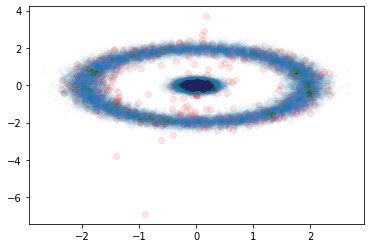

In [118]:
plt.plot(new_samples[:,0], new_samples[:,1], 'or', alpha=0.1)
plt.plot(samples[:,0], samples[:,1], '*', alpha=0.01)

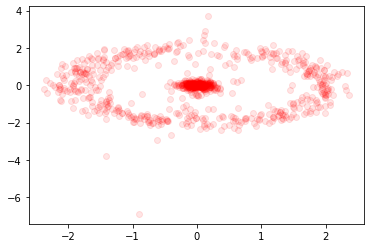

In [119]:
 plt.plot(new_samples[:,0], new_samples[:,1], 'or', alpha=0.1)
      

In [127]:
samples_base = base_dist.sample(10000)

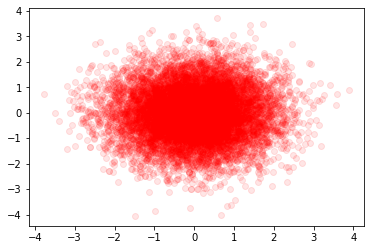

In [128]:
 plt.plot(samples_base[:,0], samples_base[:,1], 'or', alpha=0.1)
      

In [129]:
samples_base_forward = trainable_dist.bijector.forward(samples_base)

[-3, 3, -3, 3]

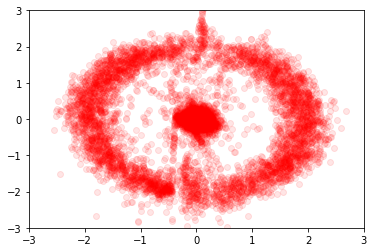

In [132]:
plt.plot(samples_base_forward[:,0], samples_base_forward[:,1], 'or', alpha=0.1)
plt.axis([-3,3,-3,3])